<a href="https://colab.research.google.com/github/harvey2phase/rrh-MNIST/blob/main/cnn_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
GDRIVE = '/content/gdrive'
drive.mount(GDRIVE)

Mounted at /content/gdrive


# Setup

In [2]:
MY_DRIVE = "/content/gdrive/My Drive/"

Successfully created the directory /content/gdrive/My Drive/rrh-MNIST/no-bn-with-drop/lat_dim=3 
Number of parameters: 17868934
Training: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
Successfully created the directory /content/gdrive/My Drive/rrh-MNIST/no-bn-with-drop/lat_dim=4 
Number of parameters: 17875080
Training: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
Successfully created the directory /content/gdrive/My Drive/rrh-MNIST/no-bn-with-drop/lat_dim=5 
Number of parameters: 17881226
Training: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,

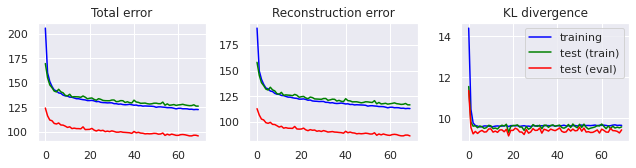

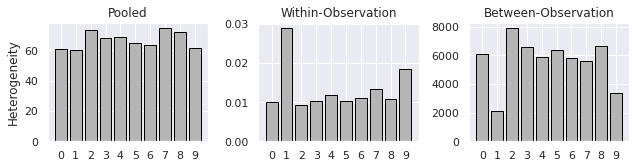

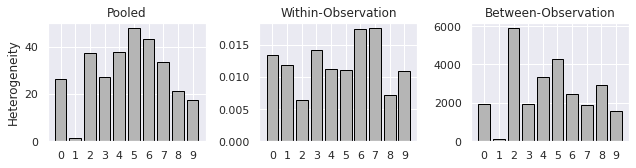

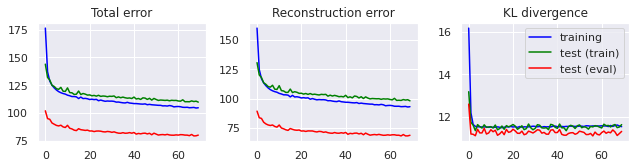

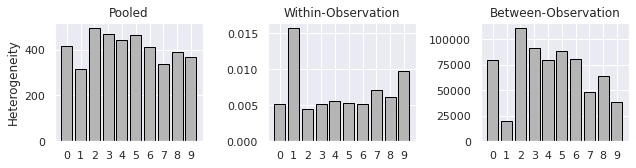

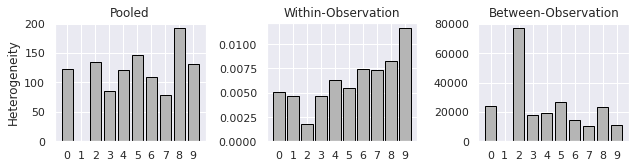

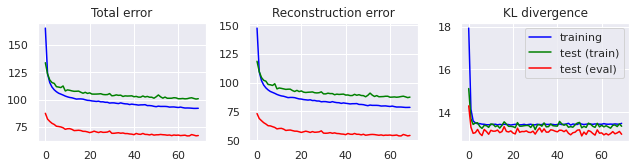

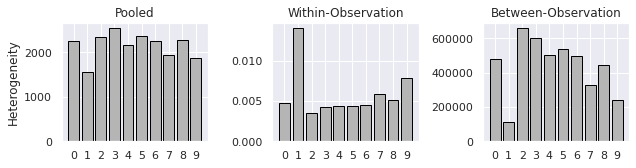

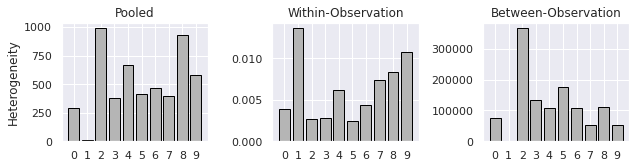

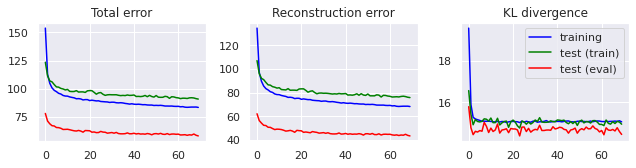

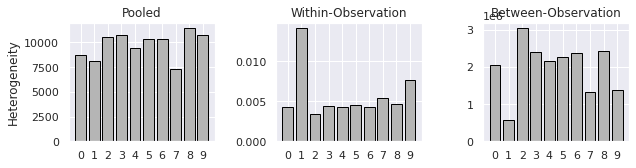

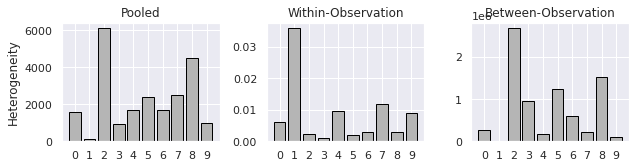

In [ ]:
import os
import sys
import urllib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.utils

MNIST_FOLDER = os.path.join(MY_DRIVE, "data")
RRH_FOLDER = os.path.join(MY_DRIVE, "rrh-MNIST")
results_folder = os.path.join(RRH_FOLDER, "no-bn-with-drop")

sys.path.insert(1, os.path.join(results_folder))
from feature_vae import new_vae, load_vae, train_vae, plot_loss

sys.path.insert(1, RRH_FOLDER)
from misc import plot, mkdir, make_exp_folder
from rrh import calculate_rrh, plot_rrh

sys.path.insert(1, os.path.join(RRH_FOLDER, "cnn-vae"))
from cnn import ConvolutionalNeuralNet, create_and_train_cnn, freeze, load_cnn
from load_mnist import load_mnist, to_numpy_arrays

GPU = True
device = torch.device("cuda:0" if GPU and torch.cuda.is_available() else "cpu")

sns.set()

# Static folder definitions ----------------------------------------------------


# Load MNIST -------------------------------------------------------------------

BATCH_SIZE = 64

train_dataloader = load_mnist(True, BATCH_SIZE, MNIST_FOLDER)
test_dataloader = load_mnist(False, BATCH_SIZE, MNIST_FOLDER)

train_X, train_y = to_numpy_arrays(train_dataloader)
test_X, test_y = to_numpy_arrays(test_dataloader)

# Train/load CNN ---------------------------------------------------------------

"""
CNN_FOLDER = os.path.join(RRH_FOLDER, "trained_cnn")
cnn = create_and_train_cnn(
    device, train_dataloader, test_dataloader, CNN_FOLDER,
)
"""
cnn = load_cnn("12-22_epoch=14.pth", device, CNN_FOLDER)
freeze(cnn)
cnn.eval()

# Train VAE --------------------------------------------------------------------

def one_vae_experiment(
    exp_folder: str,
    lat_dim,
):
    exp_folder = os.path.join(results_folder, exp_folder)
    mkdir(exp_folder)

    """
    vae, optimizer = load_vae(
        os.path.join(results_folder, exp_name, "12-21_15-18"), "vae.pth", device,
    )
    """
    vae, optimizer = new_vae(
        device,
        lat_dim = lat_dim, lrn_rate = 1e-4, vae_epoch = 70,
    )

    (
        vae, optimizer, train_losses, test_train_losses, test_eval_losses,
    ) = train_vae(
        vae, cnn, optimizer, device, train_dataloader, test_dataloader,
        evaluate = True,
    )

    torch.save(vae.state_dict(), os.path.join(exp_folder, "vae.pth"))
    torch.save(optimizer.state_dict(), os.path.join(exp_folder, "adam.pth"))
    with open(os.path.join(exp_folder, "vae.txt"), "w+") as f:
        f.write(str(vae))

    plot_loss(train_losses, test_train_losses, test_eval_losses, exp_folder)

    # Compute RRH --------------------------------------------------------------

    vae.train()
    gammas, alphas, betas = calculate_rrh(vae, cnn, device, train_X, train_y)
    plot_rrh(gammas, alphas, betas, exp_folder, "het_train")

    vae.eval()
    gammas, alphas, betas = calculate_rrh(vae, cnn, device, test_X, test_y)
    plot_rrh(gammas, alphas, betas, exp_folder, "het_test")


for lat_dim in range(3, 7):
    one_vae_experiment("lat_dim=" + str(lat_dim), lat_dim)